# **Retraining only using informative features**

## **Data and Model Import**

In [1]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
import shap
from datetime import datetime

from utils import *


datasets_folder = './datasets'
models_folder = './models'
figsize = (20,4)
verbosity = 0

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

d:\GitHub\AII-project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[]


In [2]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = list(pollution_data.keys())
agents = list(set(agent for station in stations for agent in pollution_data[station].keys()))

In [3]:
station_data = {}
station_dists = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station], station_dists[station] = prepare_station_data_for_training(
        pollution_data[station], 
        traffic_data[station], 
        weather_data, 
        encoding_method=date_encoding,
        # weather merging parameters:
        aggregations = DEFAULT_AGGREGATIONS,
        max_min_columns = DEFAULT_MAX_MIN_COLUMNS, 
        # traffic merging parameters:
        bin_size = 3,
        offset = 0
    )
    
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_hour_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
n_daily_features = len(station_data['GIARDINI MARGHERITA']['PM2.5'].columns) - 1 # -1 because Agent_value is the target
print(f'Total number of hourly features: {n_hour_features}')
print(f'Total number of daily features: {n_daily_features}')

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO2, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10
Total number of hourly features: 24
Total number of daily features: 33


## New training and test sets

We list all the features that doesnt seem to help the model or that are not really coherent.

In [4]:
shap_feature_importance = {
'GIARDINI MARGHERITA': {
       'NO2': ['Traffic_value', 'W_VEC_DIR', 'W_SCAL_INT', 'TAVG', 'RAD', 'month_rbf_1', 'RHAVG', 'month_rbf_2', 'hour_sin', 'hour_cos', 'month_rbf_12', 'month_rbf_11', 'day_cos', 'day_sin', 'month_rbf_9', 'month_rbf_5', 'month_rbf_8', 'month_rbf_7', 'month_rbf_6', 'month_rbf_3', 'LEAFW', 'month_rbf_4', 'month_rbf_10', 'PREC' ],
       'O3': ['TAVG', 'RHAVG', 'W_SCAL_INT', 'RAD', 'W_VEC_DIR', 'hour_sin', 'month_rbf_10', 'day_cos', 'Traffic_value', 'day_sin', 'hour_cos', 'month_rbf_9', 'month_rbf_1', 'LEAFW', 'month_rbf_6', 'month_rbf_11', 'month_rbf_5', 'month_rbf_2', 'month_rbf_8', 'month_rbf_12', 'month_rbf_7', 'month_rbf_3', 'month_rbf_4', 'PREC' ],
       'PM10': ['LEAFW', 'W_SCAL_INT', 'RHAVG_MIN', 'month_rbf_3', 'month_rbf_2', 'TAVG_MAX', 'month_rbf_1', 'RHAVG', 'TAVG', 'day_cos', 'day_sin', 'TAVG_MIN', 'month_rbf_12', 'month_rbf_11', 'RHAVG_MAX', 'month_rbf_8', 'PREC', 'month_rbf_10', 'RAD', 'W_VEC_DIR', 'month_rbf_7', 'month_rbf_5', 'month_rbf_4', 'month_rbf_9', 'month_rbf_6', 'Traffic_0-2', 'Traffic_9-11', 'Traffic_12-14', 'Traffic_3-5', 'Traffic_6-8', 'Traffic_21-0', 'Traffic_18-20', 'Traffic_15-17' ],
       'PM2.5': ['W_SCAL_INT', 'LEAFW', 'month_rbf_2', 'RHAVG_MIN', 'day_sin', 'RHAVG', 'month_rbf_3', 'month_rbf_12', 'TAVG_MAX', 'day_cos', 'month_rbf_1', 'TAVG_MIN', 'PREC', 'month_rbf_5', 'RHAVG_MAX', 'month_rbf_10', 'TAVG', 'month_rbf_8', 'month_rbf_11', 'W_VEC_DIR', 'month_rbf_6', 'RAD', 'month_rbf_4', 'month_rbf_7', 'month_rbf_9', 'Traffic_15-17', 'Traffic_21-0', 'Traffic_6-8', 'Traffic_3-5', 'Traffic_0-2', 'Traffic_18-20', 'Traffic_9-11', 'Traffic_12-14' ],
    },
'PORTA SAN FELICE': {
       'C6H6': ['Traffic_value', 'W_SCAL_INT', 'month_rbf_4', 'month_rbf_5', 'month_rbf_6', 'month_rbf_10', 'month_rbf_7', 'RAD', 'month_rbf_8', 'W_VEC_DIR', 'hour_cos', 'PREC', 'month_rbf_11', 'TAVG', 'day_cos', 'RHAVG', 'month_rbf_12', 'LEAFW', 'month_rbf_9', 'hour_sin', 'month_rbf_3', 'day_sin', 'month_rbf_1', 'month_rbf_2' ],
       'CO': ['TAVG', 'Traffic_value', 'hour_sin', 'W_SCAL_INT', 'month_rbf_12', 'month_rbf_1', 'month_rbf_7', 'month_rbf_8', 'hour_cos', 'month_rbf_6', 'month_rbf_9', 'month_rbf_4', 'day_sin', 'month_rbf_2', 'month_rbf_11', 'RAD', 'LEAFW', 'day_cos', 'month_rbf_3', 'month_rbf_5', 'RHAVG', 'month_rbf_10', 'PREC', 'W_VEC_DIR' ],
       'NO2': ['Traffic_value', 'hour_sin', 'hour_cos', 'TAVG', 'W_SCAL_INT', 'month_rbf_7', 'month_rbf_1', 'RAD', 'month_rbf_12', 'month_rbf_3', 'month_rbf_10', 'W_VEC_DIR', 'month_rbf_2', 'month_rbf_11', 'day_sin', 'day_cos', 'RHAVG', 'LEAFW', 'month_rbf_6', 'month_rbf_4', 'month_rbf_9', 'month_rbf_8', 'month_rbf_5', 'PREC' ],
       'PM10': ['LEAFW', 'W_SCAL_INT', 'month_rbf_2', 'RHAVG_MIN', 'month_rbf_1', 'day_sin', 'TAVG_MAX', 'day_cos', 'RHAVG', 'TAVG', 'month_rbf_3', 'RAD', 'PREC', 'month_rbf_12', 'TAVG_MIN', 'month_rbf_8', 'month_rbf_11', 'month_rbf_7', 'Traffic_6-8', 'month_rbf_10', 'month_rbf_6', 'W_VEC_DIR', 'RHAVG_MAX', 'month_rbf_5', 'month_rbf_9', 'month_rbf_4', 'Traffic_0-2', 'Traffic_3-5', 'Traffic_12-14', 'Traffic_21-0', 'Traffic_15-17', 'Traffic_9-11', 'Traffic_18-20' ],
       'PM2.5': ['W_SCAL_INT', 'LEAFW', 'month_rbf_2', 'RHAVG_MIN', 'day_sin', 'month_rbf_1', 'RHAVG', 'month_rbf_3', 'month_rbf_12', 'day_cos', 'TAVG_MIN', 'PREC', 'month_rbf_11', 'TAVG_MAX', 'W_VEC_DIR', 'month_rbf_10', 'TAVG', 'RHAVG_MAX', 'month_rbf_8', 'Traffic_6-8', 'month_rbf_6', 'month_rbf_5', 'month_rbf_7', 'RAD', 'month_rbf_4', 'Traffic_0-2', 'month_rbf_9', 'Traffic_21-0', 'Traffic_3-5', 'Traffic_15-17', 'Traffic_18-20', 'Traffic_12-14', 'Traffic_9-11' ],
    },
'VIA CHIARINI': {
       'NO2': ['Traffic_value', 'hour_cos', 'RHAVG', 'TAVG', 'hour_sin', 'month_rbf_1', 'W_SCAL_INT', 'month_rbf_12', 'month_rbf_2', 'month_rbf_3', 'W_VEC_DIR', 'month_rbf_11', 'month_rbf_6', 'month_rbf_8', 'day_cos', 'RAD', 'day_sin', 'month_rbf_4', 'month_rbf_5', 'month_rbf_9', 'month_rbf_7', 'LEAFW', 'month_rbf_10', 'PREC' ],
       'O3': ['PREC', 'hour_cos', 'month_rbf_8', 'TAVG', 'W_SCAL_INT', 'month_rbf_7', 'month_rbf_2', 'month_rbf_11', 'month_rbf_6', 'RAD', 'RHAVG', 'day_cos', 'Traffic_value', 'month_rbf_5', 'W_VEC_DIR', 'month_rbf_1', 'month_rbf_10', 'month_rbf_9', 'day_sin', 'month_rbf_12', 'hour_sin', 'LEAFW', 'month_rbf_4', 'month_rbf_3' ],
       'PM10': ['W_SCAL_INT', 'LEAFW', 'month_rbf_2', 'month_rbf_3', 'RHAVG_MIN', 'RAD', 'day_sin', 'TAVG_MIN', 'TAVG_MAX', 'day_cos', 'TAVG', 'RHAVG', 'month_rbf_1', 'month_rbf_12', 'RHAVG_MAX', 'month_rbf_8', 'Traffic_3-5', 'month_rbf_11', 'Traffic_6-8', 'W_VEC_DIR', 'month_rbf_7', 'PREC', 'month_rbf_9', 'month_rbf_6', 'month_rbf_10', 'Traffic_9-11', 'month_rbf_5', 'Traffic_21-0', 'month_rbf_4', 'Traffic_0-2', 'Traffic_18-20', 'Traffic_12-14', 'Traffic_15-17' ],
    },
}

In [6]:
training_sets_informative = {}
test_sets_informative = {}
train_split_date = datetime(2023,12,31,23)
target = 'Agent_value'
num_keep=10

for station in stations:
    training_sets_informative[station] = {}
    test_sets_informative[station] = {}
    for agent in station_data[station].keys():
        training_sets_informative[station][agent] = {}
        test_sets_informative[station][agent] = {}

        x_train, y_train, x_test, y_test = create_train_test(station_data[station][agent].drop(columns=shap_feature_importance[station][agent][num_keep:]), train_split_date, y=target)

        training_sets_informative[station][agent]['x'] = x_train
        training_sets_informative[station][agent]['y'] = y_train
        test_sets_informative[station][agent]['x'] = x_test
        test_sets_informative[station][agent]['y'] = y_test

In [7]:
models_informative = get_models(num_keep, num_keep)

In [8]:
agents_predictions_informative = train_agents(models_informative, training_sets_informative, test_sets_informative)

Predicting NO2 in GIARDINI MARGHERITA using LSTM-masked...
Predicting O3 in GIARDINI MARGHERITA using LSTM_2-masked...
Predicting PM10 in GIARDINI MARGHERITA using Random Forest Regressor...
Predicting PM2.5 in GIARDINI MARGHERITA using Feed Forward NN BatchNorm...
Predicting C6H6 in PORTA SAN FELICE using LSTM-masked...
Predicting CO in PORTA SAN FELICE using Feed Forward NN...
Predicting NO2 in PORTA SAN FELICE using Conv1D...
Predicting PM10 in PORTA SAN FELICE using Feed Forward NN...
Predicting PM2.5 in PORTA SAN FELICE using Feed Forward NN...
Predicting NO2 in VIA CHIARINI using Feed Forward NN...
Predicting O3 in VIA CHIARINI using LSTM_2-masked...
Predicting PM10 in VIA CHIARINI using Feed Forward NN...


In [9]:
metrics_predictions_informative = training_results_to_dataframe(agents_predictions_informative, multiple_models=False)
metrics_predictions_informative

,Station,Agent,root_mean_squared_error,r2_score,mean_absolute_error,huber
0,GIARDINI MARGHERITA,NO2,0.555869,0.561150,0.377842,0.058963
1,GIARDINI MARGHERITA,O3,0.378566,0.838947,0.283188,0.040376
2,GIARDINI MARGHERITA,PM10,0.764903,0.352665,0.545315,0.090782
3,GIARDINI MARGHERITA,PM2.5,0.760116,0.427186,0.556309,0.092441
4,PORTA SAN FELICE,C6H6,0.580624,0.635258,0.362267,0.055696
5,PORTA SAN FELICE,CO,0.775642,0.425330,0.599143,0.101564
6,PORTA SAN FELICE,NO2,1.065685,-1.105357,0.899166,0.160515
7,PORTA SAN FELICE,PM10,0.753800,0.438086,0.518759,0.085678
8,PORTA SAN FELICE,PM2.5,0.657452,0.581139,0.480366,0.077646
9,VIA CHIARINI,NO2,0.634715,0.346730,0.483937,0.078775


In [10]:
agents_predictions_informative_original_dist = agents_predictions_informative.copy()
test_sets_informative_original_dist = test_sets_informative.copy()

In [11]:
for station in stations:
    for agent in agents_predictions_informative_original_dist[station]:
        test_sets_informative_original_dist[station][agent]['y'] = (test_sets_informative_original_dist[station][agent]['y'] * station_dists[station][agent]['std']) + station_dists[station][agent]['mean']
        agents_predictions_informative_original_dist[station][agent]['predictions'] = (agents_predictions_informative_original_dist[station][agent]['predictions'] * station_dists[station][agent]['std']) + station_dists[station][agent]['mean']

Station GIARDINI MARGHERITA Hourly


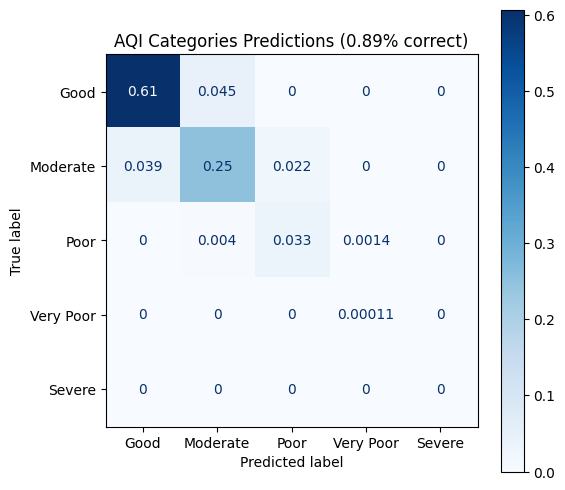

---------------------------------------------
> Absolute Mean AQI Difference: 8.44
> Positive Average AQI Difference: 8.51
> Negative Average AQI Difference: -8.35
> Percentage of Positive Differences: 57.35%
> Percentage of Negative Differences: 42.43%
> Percentage of Agent Values:
   - Same agent: 87.68
   - Different agents: 12.32
Station PORTA SAN FELICE Hourly


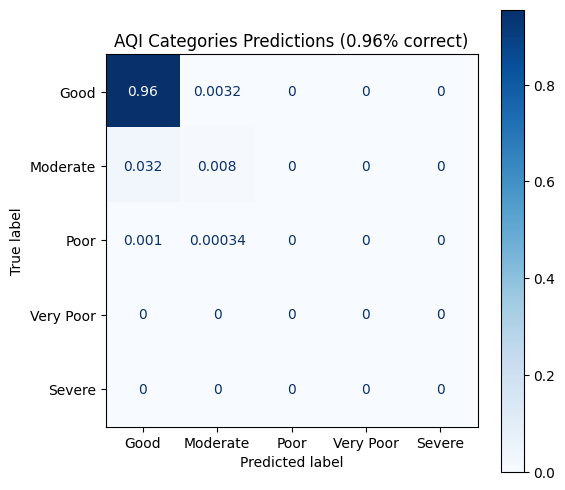

---------------------------------------------
> Absolute Mean AQI Difference: 6.64
> Positive Average AQI Difference: 6.15
> Negative Average AQI Difference: -7.54
> Percentage of Positive Differences: 64.74%
> Percentage of Negative Differences: 35.06%
> Percentage of Agent Values:
   - Same agent: 56.06
   - Different agents: 43.94
Station VIA CHIARINI Hourly


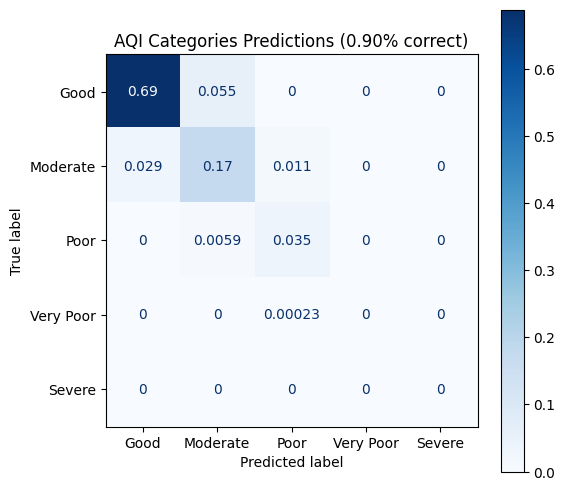

---------------------------------------------
> Absolute Mean AQI Difference: 8.59
> Positive Average AQI Difference: 9.54
> Negative Average AQI Difference: -7.17
> Percentage of Positive Differences: 59.53%
> Percentage of Negative Differences: 40.16%
> Percentage of Agent Values:
   - Same agent: 84.8
   - Different agents: 15.2
Station GIARDINI MARGHERITA Daily


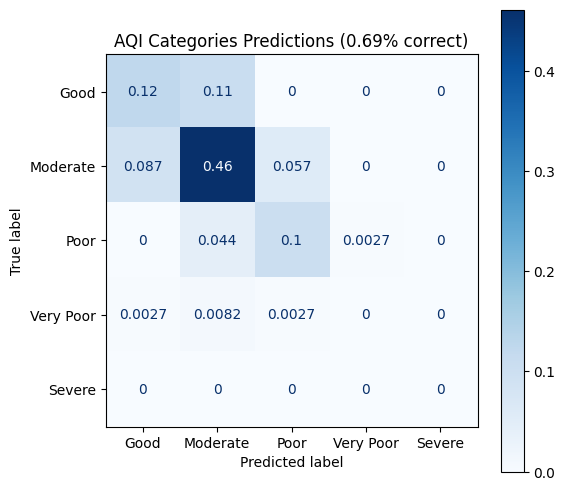

---------------------------------------------
> Absolute Mean AQI Difference: 14.48
> Positive Average AQI Difference: 12.46
> Negative Average AQI Difference: -17.86
> Percentage of Positive Differences: 62.57%
> Percentage of Negative Differences: 37.43%
> Percentage of Agent Values:
   - Same agent: 74.86
   - Different agents: 25.14
Station PORTA SAN FELICE Daily


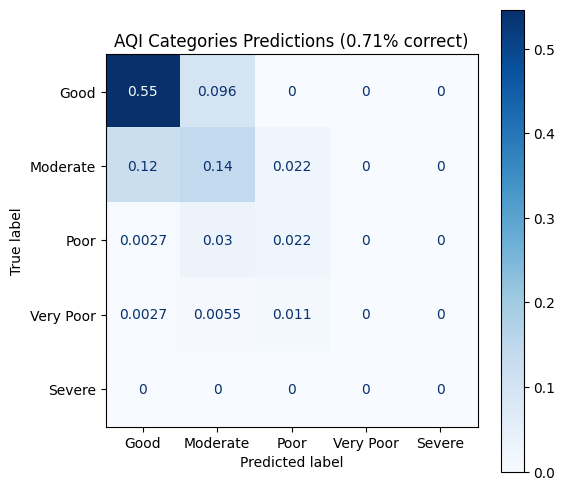

---------------------------------------------
> Absolute Mean AQI Difference: 15.52
> Positive Average AQI Difference: 13.17
> Negative Average AQI Difference: -19.06
> Percentage of Positive Differences: 60.11%
> Percentage of Negative Differences: 39.89%
> Percentage of Agent Values:
   - Same agent: 84.43
   - Different agents: 15.57
Station VIA CHIARINI Daily


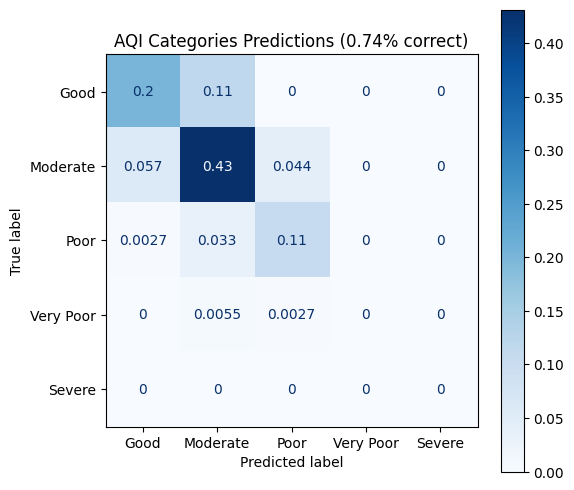

---------------------------------------------
> Absolute Mean AQI Difference: 13.06
> Positive Average AQI Difference: 12.57
> Negative Average AQI Difference: -13.79
> Percentage of Positive Differences: 59.84%
> Percentage of Negative Differences: 40.16%
> Percentage of Agent Values:
   - Same agent: 86.07
   - Different agents: 13.93


In [12]:
compute_AQI_and_show_analysis(agents_predictions_informative_original_dist, test_sets_informative_original_dist)